In [63]:

import gc
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix, hstack
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
import lightgbm as lgb

df = pd.read_csv('C:\\train.tsv', sep = '\t')


msk = np.random.rand(len(df)) < 0.8
train = df[msk]
test = df[~msk]
train.shape, test.shape


train.price.describe()



count    1.185642e+06
mean     2.671848e+01
std      3.850635e+01
min      0.000000e+00
25%      1.000000e+01
50%      1.700000e+01
75%      2.900000e+01
max      2.009000e+03
Name: price, dtype: float64

Text(0.5, 1.0, 'Price Distribution')

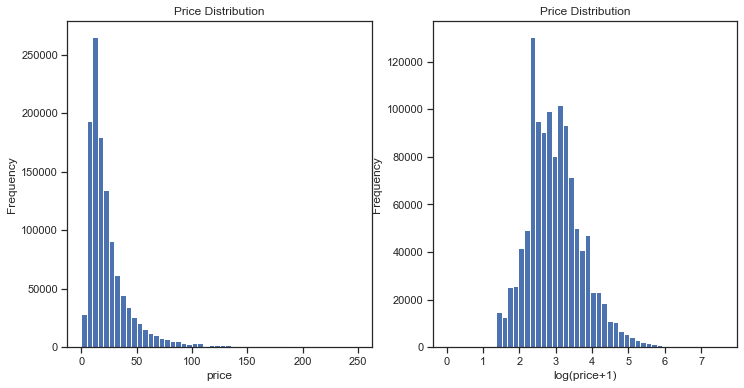

In [64]:

plt.subplot(1, 2, 1)
(train['price']).plot.hist(bins=50, figsize=(12, 6), edgecolor = 'white', range = [0, 250])
plt.xlabel('price', fontsize=12)
plt.title('Price Distribution', fontsize=12)
plt.subplot(1, 2, 2)
np.log(train['price']+1).plot.hist(bins=50, figsize=(12,6), edgecolor='white')
plt.xlabel('log(price+1)', fontsize=12)
plt.title('Price Distribution', fontsize=12)


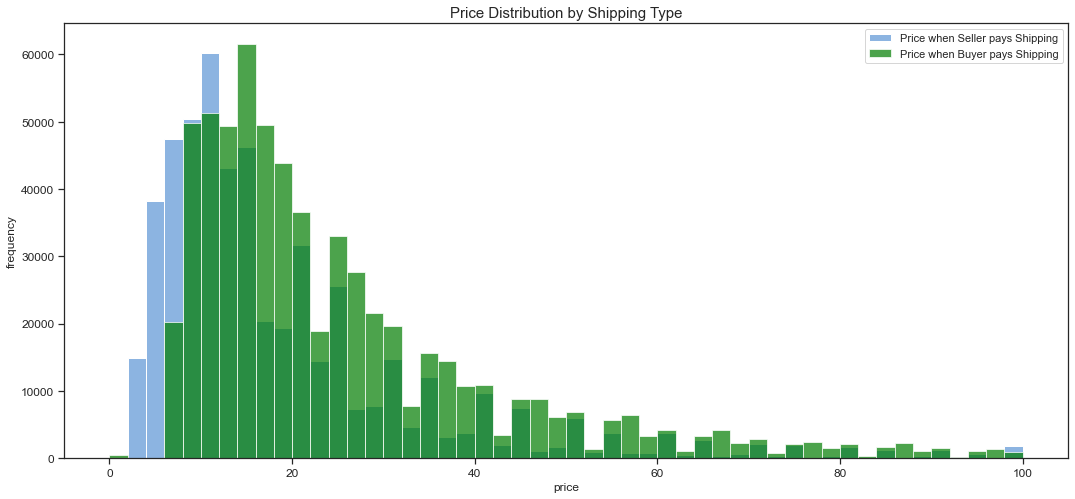

In [65]:
train['shipping'].value_counts() / len(train)

shipping_fee_by_buyer = train.loc[df['shipping'] == 0, 'price']
shipping_fee_by_seller = train.loc[df['shipping'] == 1, 'price']
fig, ax = plt.subplots(figsize=(18,8))
ax.hist(shipping_fee_by_seller, color='#8CB4E1', alpha=1.0, bins=50, range = [0, 100],
       label='Price when Seller pays Shipping')
ax.hist(shipping_fee_by_buyer, color='#007D00', alpha=0.7, bins=50, range = [0, 100],
       label='Price when Buyer pays Shipping')
plt.xlabel('price', fontsize=12)
plt.ylabel('frequency', fontsize=12)
plt.title('Price Distribution by Shipping Type', fontsize=15)
plt.tick_params(labelsize=12)
plt.legend()
plt.show()


In [66]:

print('The average price is {}'.format(round(shipping_fee_by_seller.mean(), 2)), 'if seller pays shipping');
print('The average price is {}'.format(round(shipping_fee_by_buyer.mean(), 2)), 'if buyer pays shipping')

 # Result:
The average price is 22.54 if seller pays shipping
The average price is 30.13 if buyer pays shipping


fig, ax = plt.subplots(figsize=(18,8))
ax.hist(np.log(shipping_fee_by_seller+1), color='#8CB4E1', alpha=1.0, bins=50,
       label='Price when Seller pays Shipping')
ax.hist(np.log(shipping_fee_by_buyer+1), color='#007D00', alpha=0.7, bins=50,
       label='Price when Buyer pays Shipping')
plt.xlabel('log(price+1)', fontsize=12)
plt.ylabel('frequency', fontsize=12)
plt.title('Price Distribution by Shipping Type', fontsize=15)
plt.tick_params(labelsize=12)
plt.legend()
plt.show()


SyntaxError: invalid syntax (<ipython-input-66-84189488a967>, line 5)

There are 1268 unique values in category name column


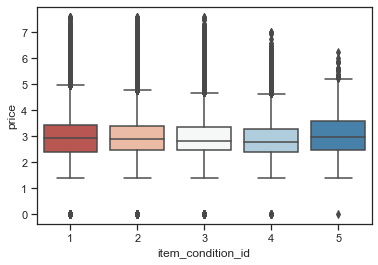

In [67]:

print('There are', train['category_name'].nunique(), 'unique values in category name column')
train['category_name'].value_counts()[:10]



sns.boxplot(x = 'item_condition_id', y = np.log(train['price']+1), data = train, palette = sns.color_palette('RdBu',5))
 


In [ ]:

# Light GMB
# LightGBM is a gradient boosting framework that uses tree based learning algorithms. It is designed to be distributed and efficient with the following advantages:
# Faster training speed and higher efficiency
# Lower memory usage
# Better accuracy
# Parallel and GPU learning supported
# Capable of handling large-scale data

NUM_BRANDS = 4000
NUM_CATEGORIES = 1000
NAME_MIN_DF = 10
MAX_FEATURES_ITEM_DESCRIPTION = 50000

# There are missing values in the columns that we have to fix:
print('There are %d items that do not have a category name.' %train['category_name'].isnull().sum())


print('There are %d items that do not have a brand name.' %train['brand_name'].isnull().sum())


# helper function for light GBM:
def handle_missing_inplace(dataset): 
    dataset['category_name'].fillna(value='missing', inplace=True) 
    dataset['brand_name'].fillna(value='missing', inplace=True) 
    dataset['item_description'].replace('No description yet,''missing', inplace=True) 
    dataset['item_description'].fillna(value='missing', inplace=True)
def cutting(dataset):
    pop_brand = dataset['brand_name'].value_counts().loc[lambda x: x.index != 'missing'].index[:NUM_BRANDS]
    dataset.loc[~dataset['brand_name'].isin(pop_brand), 'brand_name'] = 'missing'
    pop_category = dataset['category_name'].value_counts().loc[lambda x: x.index != 'missing'].index[:NUM_CATEGORIES]
def to_categorical(dataset):
    dataset['category_name'] = dataset['category_name'].astype('category')
    dataset['brand_name'] = dataset['brand_name'].astype('category')
    dataset['item_condition_id'] = dataset['item_condition_id'].astype('category')


# Drop rows where price = 0
df = pd.read_csv('C:\\train.tsv', sep = '\t')
msk = np.random.rand(len(df)) < 0.8
train = df[msk]
test = df[~msk]
test_new = test.drop('price', axis=1)
y_test = np.log1p(test["price"])
train = train[train.price != 0].reset_index(drop=True)

# Merge train and new test data.
nrow_train = train.shape[0]
y = np.log1p(train["price"])
merge: pd.DataFrame = pd.concat([train, test_new])

    
handle_missing_inplace(merge)
cutting(merge)
to_categorical(merge)

# Count vectorize name and category name columns.
cv = CountVectorizer(min_df=NAME_MIN_DF)
X_name = cv.fit_transform(merge['name'])
cv = CountVectorizer()
X_category = cv.fit_transform(merge['category_name'])


# TF-IDF Vectorize item_description column.
tv = TfidfVectorizer(max_features=MAX_FEATURES_ITEM_DESCRIPTION, ngram_range=(1, 3), stop_words='english')
X_description = tv.fit_transform(merge['item_description'])


# Label binarize brand_name column.
lb = LabelBinarizer(sparse_output=True)
X_brand = lb.fit_transform(merge['brand_name'])

# Create dummy variables for item_condition_id and shipping columns.
X_dummies = csr_matrix(pd.get_dummies(merge[['item_condition_id', 'shipping']], sparse=False).values)


# Create sparse merge.
sparse_merge = hstack((X_dummies, X_description, X_brand, X_category, X_name)).tocsr()


# Remove features with document frequency <=1.
mask = np.array(np.clip(sparse_merge.getnnz(axis=0) - 1, 0, 1), dtype=bool)
sparse_merge = sparse_merge[:, mask]


# Separate train and test data from sparse merge.
X = sparse_merge[:nrow_train]
X_test = sparse_merge[nrow_train:]


# Create dataset for lightgbm.
train_X = lgb.Dataset(X, label=y)
# Specify our parameters as a dict.
params = {
        'learning_rate': 0.75,
        'application': 'regression',
        'max_depth': 3,
        'num_leaves': 100,
        'verbosity': -1,
        'metric': 'RMSE',
    }


# Training Start
# Training a model requires a parameter list and data set. And training will take a while.
gbm = lgb.train(params, train_set=train_X, num_boost_round=3200, verbose_eval=100)


# Predict
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)


# Evaluation
from sklearn.metrics import mean_squared_error
print('The rmse of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)


There are 5065 items that do not have a category name.
There are 505903 items that do not have a brand name.


In [ ]:

# data:
#  https://www.kaggle.com/saitosean/mercari.
